In [1]:
import pytorch_lightning as pl
from models import *
from data.data_classes import *

In [2]:
batch_size = 4

num_ctx_frames=5
num_tgt_frames=5
split_ratio=[0.4, 0.1, 0.5]

moving_mnist = TwoColourMovingMNISTDataModule(batch_size,               
                                              num_ctx_frames, 
                                              num_tgt_frames,
                                              split_ratio=split_ratio)

moving_mnist.setup()
train_dl = moving_mnist.train_dataloader()
train_ctx_frames, train_tgt_frames = next(iter(train_dl))

val_dl = moving_mnist.val_dataloader()
val_ctx_frames, val_tgt_frames = next(iter(val_dl))                                              

In [3]:
input_channels=3
num_hidden=[64, 64, 64]
kernel_size=5
stride=1
learning_rate=1e-3

# Experiment 1 (mse)
model = PredRNN(input_channels=input_channels,
                num_hidden=num_hidden,
                num_ctx_frames=num_ctx_frames,
                num_tgt_frames=num_tgt_frames,
                kernel_size=kernel_size,
                stride=stride)
model = model.load_from_checkpoint("./logs/PredRNN_RGB/experiment1/checkpoints/epoch=99-step=25000.ckpt")
model.eval()

PredRNN(
  (loss): L1Loss()
  (ssim): SSIM()
  (psnr): PSNR()
  (cell_list): ModuleList(
    (0): SpatioTemporalLSTMCell(
      (conv_x): Sequential(
        (0): Conv2d(3, 448, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      )
      (conv_h): Sequential(
        (0): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      )
      (conv_m): Sequential(
        (0): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      )
      (conv_o): Sequential(
        (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      )
      (conv_last): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): SpatioTemporalLSTMCell(
      (conv_x): Sequential(
        (0): Conv2d(64, 448, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      )
      (conv_h): Sequential(
        (0): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False

In [4]:
index = 0

full_sequence = torch.zeros(1, 3, 10, 128, 128)
full_sequence[:, :, :5] = val_ctx_frames[index]

all_output = torch.zeros(5, 3, 5, 128, 128)

for i in range(5, 10):
    predrnn_input = torch.zeros(1, 3, 6, 128, 128)
    predrnn_input[:, :, :5] = full_sequence[:, :, i-5:i]
    predrnn_input[:, :, 5] =  full_sequence[:, :, i-1]

    all_output[i-5] = model(predrnn_input)
    full_sequence[:, :, i] = all_output[i-5:i-4, :, -1]

full_sequence.shape

torch.Size([1, 3, 10, 128, 128])

In [11]:
index = 1

full_sequence = torch.zeros(1, 3, 7, 128, 128)
full_sequence[:, :, :5] = val_ctx_frames[index]

# all_output = torch.zeros(5, 3, 5, 128, 128)

for i in range(5, 6):
    predrnn_input = torch.zeros(1, 3, i+1, 128, 128)
    print(predrnn_input.shape)
    predrnn_input[:, :, :i] = full_sequence[:, :, :i]
    predrnn_input[:, :, i] =  full_sequence[:, :, i-1]

    output = model(predrnn_input)
    full_sequence[:, :, i] = output[:, :, -1]

full_sequence.shape

torch.Size([1, 3, 6, 128, 128])


torch.Size([1, 3, 7, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(5, 128, 128, 3)


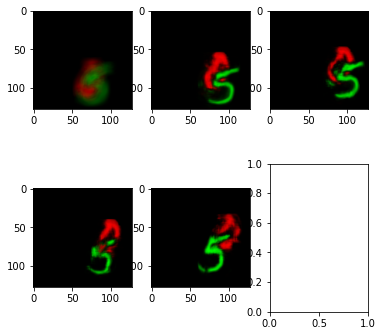

In [12]:
id = 0
nrow = 2
ncol = 3
nframes = 5
fig, ax = plt.subplots(nrow, ncol,
                       figsize = (6, 6))
frames = output[id].permute(1, 2, 3, 0).detach().numpy()
print(frames.shape)     

for i in range(nframes):
    ax[i//ncol, i%ncol].imshow(frames[i])

In [13]:
def make_thesis_plot(frame_sets, names, plot_width, plot_height):

    def show_frames(frames, ax, start_id, row_label=None):
        for i, frame in enumerate(frames):
            ax[i].imshow(frame)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_xlabel(f"t={start_id+i}")
            ax[i].xaxis.set_label_coords(.52, 1.15)

        if row_label is not None:
            ax[0].set_ylabel(row_label, wrap=True)

    fig, ax = plt.subplots(len(frame_sets), 5,
                               figsize = (plot_width, plot_height))

    for i, frames in enumerate(frame_sets):
        frames = frames.squeeze().permute(1, 2, 3, 0).cpu().detach().numpy()
        show_frames(frames, ax[i], 5, names[i])
    fig.set_facecolor("white")
    
    return fig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


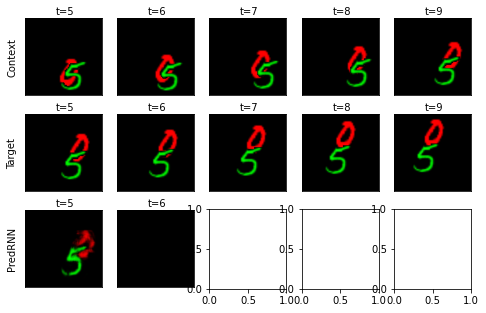

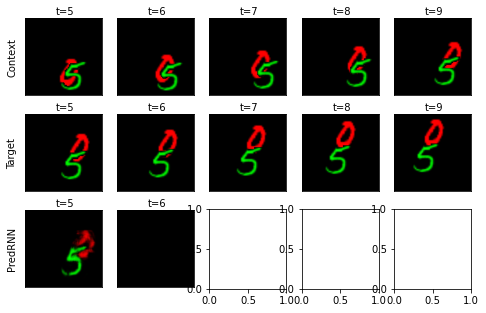

In [15]:
index = 0
plot_width = 8
plot_height = 5
frame_sets = [val_ctx_frames[1],
              val_tgt_frames[1],
              full_sequence[0, :, 5:]]

names = ["Context", "Target",
         "PredRNN"]               
make_thesis_plot(frame_sets, names, plot_width, plot_height)

## Predict 1 to 9

In [ ]:
batch_size = 4

num_ctx_frames=1
num_tgt_frames=9
split_ratio=[0.4, 0.1, 0.5]

moving_mnist = TwoColourMovingMNISTDataModule(batch_size,               
                                              num_ctx_frames, 
                                              num_tgt_frames,
                                              split_ratio=split_ratio)

moving_mnist.setup()
train_dl = moving_mnist.train_dataloader()
train_ctx_frames, train_tgt_frames = next(iter(train_dl))

val_dl = moving_mnist.val_dataloader()
val_ctx_frames, val_tgt_frames = next(iter(val_dl))                                              

In [ ]:
input_channels=3
num_hidden=[64, 64, 64]
kernel_size=5
stride=1
learning_rate=1e-3

model = PredRNN(input_channels=input_channels,
                num_hidden=num_hidden,
                num_ctx_frames=num_ctx_frames,
                num_tgt_frames=num_tgt_frames,
                kernel_size=kernel_size,
                stride=stride)
model = model.load_from_checkpoint("./logs/PredRNN_RGB/experiment3/checkpoints/epoch=99-step=25000.ckpt")

### Method 1: Repeat first frame to use as input

In [ ]:
index = 0
input = val_ctx_frames[index:index+1].repeat(1, 1, 10, 1,1)

In [ ]:
model.eval()
pred_frames = model(input)
pred_frames.shape

In [ ]:
id = 0
nrow = 3
ncol = 3
nframes = 9
fig, ax = plt.subplots(nrow, ncol,
                       figsize = (6, 6))
frames = pred_frames[id].permute(1, 2, 3, 0).detach().numpy()
print(frames.shape)     

for i in range(nframes):
    ax[i//ncol, i%ncol].imshow(frames[i])

### Method 2: Autoregressively

In [ ]:
model.eval()

index = 0
input = val_ctx_frames[index:index+1].repeat(1, 1, 2, 1, 1)

full_sequence = torch.zeros(1, 3, 10, 128, 128)
full_sequence[:, :, 0:1] = val_ctx_frames[index]

for i in range(1, 10):
    input = full_sequence[:, :, i-1:i].repeat(1, 1, 2, 1, 1)
    full_sequence[:, :, i:i+1] = model(input)

full_sequence.shape

In [ ]:
id = 0
nrow = 2
ncol = 5
nframes = 10
fig, ax = plt.subplots(nrow, ncol,
                       figsize = (6, 6))
frames = full_sequence[id].permute(1, 2, 3, 0).detach().numpy()
print(frames.shape)     

for i in range(nframes):
    ax[i//ncol, i%ncol].imshow(frames[i])